In [3]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a encoder block of the VAE, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Encoder: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

class Decoder(nn.Module):
    '''
    Decoder Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 2, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim * 2, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim * 2, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim * 2, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim * 2, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a Decoder block of the VAE, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [4]:
k = 4
s = 2

w = 1
h = 1


def block (w, h, k, s):
    w = (w - 1)*s + k
    h = (h - 1)*s + k
    return w, h

w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)



print(w, h)

94 94


In [5]:
def block (w, h, k, s):
    w = (w - k)//s + 1
    h = (h - k)//s + 1
    return w, h

h = 94
w = 94

w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)



print(w, h)

1 1


In [6]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    '''
    VAE Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        images: an image tensor with dimensions (batch_size, im_chan, im_height, im_width)
        Returns:
        decoding: the autoencoded image
        q_dist: the z-distribution of the encoding
        '''
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        decoding = self.decode(z_sample)
        print(decoding.shape)
        return decoding, q_dist

In [7]:
reconstruction_loss = nn.BCELoss(reduction='sum')

In [9]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def pre_process(img, binarize_at=0.0, resize_to=(0,0)):
    if binarize_at > 0.0:
        thresh = int(binarize_at * np.max(img))
        # Replace all values in img that are less than the max value with 0
        img[img<thresh] = 0
        img[img>=thresh] = 255

    if resize_to != (0,0):
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_CUBIC)
    
    if binarize_at > 0.0:
        thresh = int(binarize_at * np.max(img))
        # Replace all values in img that are less than the max value with 0
        img[img<thresh] = 0
        img[img>=thresh] = 255


    return img

(288, 512)


(-0.5, 93.5, 93.5, -0.5)

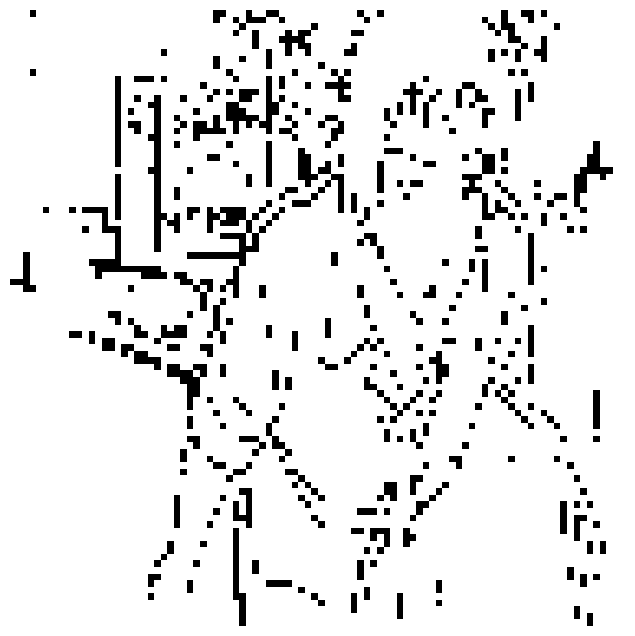

In [14]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('frame2.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
img = pre_process(img, binarize_at=0.75, resize_to=(94,94))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

In [15]:
from torch.utils.data import Dataset
import os
import cv2

class MyDataset(Dataset):
    def __init__(self, data, transform=None, binarize_at=0.0, resize_to=(94,94)):
        self.data = data
        self.transform = transform
        self.binarize_at = binarize_at
        self.resize_to = resize_to

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        triplet_path = self.data[idx]
        #Extracts all three frames of the triplet
        triplet = []
        for img_path in os.listdir(triplet_path):
            img = cv2.imread(os.path.join(triplet_path, img_path), cv2.IMREAD_GRAYSCALE)
            if self.binarize_at > 0.0 or self.resize_to != (0,0):
                img = pre_process(img, binarize_at=self.binarize_at, resize_to=self.resize_to)
            if self.transform:
                img = self.transform(img)
            triplet.append(img)
        return triplet[0], triplet[1], triplet[2]

In [16]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
import os

data_dir = '/data/farriaga/atd_12k/Line_Art/train_10k'
triplet_paths = [os.path.join(data_dir, p) for p in os.listdir(data_dir)]
transform=transforms.Compose([
    transforms.ToTensor(),
])
my_dataset = MyDataset(triplet_paths, transform=transform, binarize_at=0.75, resize_to=(94, 94))
train_dataloader = DataLoader(my_dataset, batch_size=2048, shuffle=True)

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

losses = []
device = 'cuda:1'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)
for epoch in range(500):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    epoch_loss = 0
    for images, _, __ in tqdm(train_dataloader):
        images = images.to(device)
        vae_opt.zero_grad() # Clear out the gradients
        recon_images, encoding = vae(images)
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
        loss.backward()
        vae_opt.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)

    # Plot the list of losses
    plt.plot(losses)
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2048, 1, 94, 94])


 20%|██        | 1/5 [00:07<00:29,  7.43s/it]

torch.Size([2048, 1, 94, 94])


 40%|████      | 2/5 [00:14<00:21,  7.22s/it]

torch.Size([2048, 1, 94, 94])


 60%|██████    | 3/5 [00:22<00:15,  7.58s/it]


KeyboardInterrupt: 

: 

This is the block configuration to use in case I want to maintain the original image aspect/ratio (approx 1:2)

In [19]:
k = 4
s = 2

w = 1
h = 3


def block (w, h, k, s):
    w = (w - 1)*s + k
    h = (h - 1)*s + k
    return w, h

w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)
w, h = block(w, h, 4, 2)



print(w, h)

94 158
